In [1]:
from pandas import read_csv
from matplotlib import pyplot
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd 

In [2]:
dataset = read_csv('train.csv', header=0, index_col=0)
dataset


,Wind Speed,Pressure,Relative Humidity,Temperature,Solar Radiation
date,,,,,
2011-01-01 00:00:00,3.011042,986.761841,72.295858,13.522659,0
2011-01-01 01:00:00,3.091243,986.441406,75.376186,12.835814,0
2011-01-01 02:00:00,3.007649,985.736511,78.405198,12.198058,0
2011-01-01 03:00:00,2.926715,985.525696,81.042980,11.583500,0
2011-01-01 04:00:00,2.915177,985.661926,82.548508,11.029578,0
...,...,...,...,...,...
2012-12-31 19:00:00,3.383211,984.779114,22.647353,14.702595,0
2012-12-31 20:00:00,3.519155,985.189148,23.993252,13.823766,0
2012-12-31 21:00:00,3.518434,984.829224,25.759637,12.951590,0


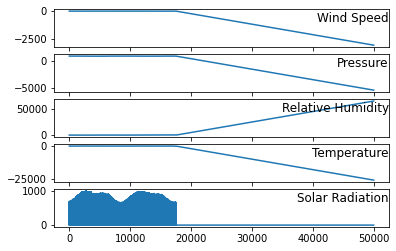

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1    0.410768   0.769512   0.720381   0.074662   0.000000  0.421819  0.758308   
2    0.421819   0.758308   0.751471   0.063017   0.000000  0.410300  0.733658   
3    0.410300   0.733658   0.782043   0.052629   0.000000  0.399148  0.726288   
4    0.399148   0.726288   0.808666   0.043324   0.000000  0.397558  0.731049   
5    0.397558   0.731049   0.823861   0.034933   0.000000  0.262890  0.733192   
6    0.262890   0.733192   0.649555   0.007592   0.000000  0.245979  0.751583   
7    0.245979   0.751583   0.667870   0.006165   0.000000  0.218438  0.779202   
8    0.218438   0.779202   0.637009   0.013985   0.000000  0.194155  0.809219   
9    0.194155   0.809219   0.546880   0.052001   0.158841  0.142382  0.820221   
10   0.142382   0.820221   0.466754   0.101147   0.362637  0.071046  0.814716   
11   0.071046   0.814716   0.361586   0.186997   0.532468  0.130909  0.794060   
12   0.130909   0.794060   0

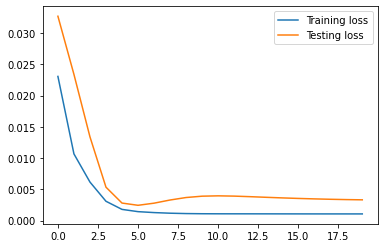

Test RMSE: 0.418
Test MAPE 20.0142


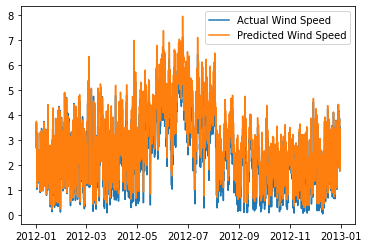

In [3]:
dataset = read_csv('train1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3,4]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg
dataset = read_csv('train.csv', header=0, index_col=0)
values = dataset.values
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head(15))
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head(15))
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile( optimizer='adam',loss='mean_squared_error')
model.summary()
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1)
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False,callbacks = [early_stop])
pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Testing loss')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_predicted = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_predicted = scaler.inverse_transform(inv_predicted)
inv_predicted = inv_predicted[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_actual = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]
rmse = np.sqrt(mean_squared_error(inv_actual, inv_predicted))
print('Test RMSE: %.3f' % rmse)

mape=np.mean(np.abs((inv_actual - inv_predicted) / inv_actual)) * 100
print('Test MAPE %.4f' % mape)

t = pd.date_range('1/1/2012', periods =8759, freq = 'H')
pyplot.plot(t,inv_actual,label='Actual Wind Speed')
pyplot.plot(t,inv_predicted,label='Predicted Wind Speed')
pyplot.legend()
pyplot.show()
